In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [21]:
start_date = pd.to_datetime('2000-01-03')
end_date = pd.to_datetime('2014-03-31')

data = pd.read_csv('/content/oxfordmanrealizedvolatilityindices.csv')


<ipython-input-21-3fdb5ca91ccb>:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/oxfordmanrealizedvolatilityindices.csv')


In [22]:

data['Symbol'] = data['Symbol'].str.lstrip('.')
data['Symbol'].unique()

array(['AEX', 'AORD', 'BFX', 'BSESN', 'BVLG', 'BVSP', 'DJI', 'FCHI',
       'FTMIB', 'FTSE', 'GDAXI', 'GSPTSE', 'HSI', 'IBEX', 'IXIC', 'KS11',
       'KSE', 'MXX', 'N225', 'NSEI', 'OMXC20', 'OMXHPI', 'OMXSPI',
       'OSEAX', 'RUT', 'SMSI', 'SPX', 'SSEC', 'SSMI'], dtype=object)

In [23]:

datasets = {} #to store the dataset

for symbol in data['Symbol'].unique():
    symbol_data = data[data['Symbol'] == symbol].copy()
    symbol_data = symbol_data.drop(columns=['Symbol'])

    symbol_data.index = pd.to_datetime(symbol_data['Unnamed: 0'].astype(str).str[:10])

    symbol_data = symbol_data[(symbol_data.index >= start_date) & (symbol_data.index <= end_date)]
    symbol_data.index.names = ['Date']
    symbol_data=symbol_data.drop(columns='Unnamed: 0')

    symbol_data.to_csv(f'{symbol}.csv')
    datasets[symbol] = symbol_data


In [ ]:
'''
IXIC_data = pd.read_csv('/content/IXIC_data.csv',index_col='Unnamed: 0')
IXIC_data.index = pd.to_datetime(IXIC_data.index, format='%Y/%m/%d')
IXIC_data.index.names = ['Date']

SPX_data = pd.read_csv('/content/SPX_data.csv',index_col='Unnamed: 0')
SPX_data.index = pd.to_datetime(SPX_data.index, format='%Y/%m/%d')
SPX_data.index.names = ['Date']

IXIC_data=IXIC_data.drop(columns='Unnamed: 0.1')
SPX_data=SPX_data.drop(columns='Unnamed: 0.1')
start_date = pd.to_datetime('2000-01-03')
end_date = pd.to_datetime('2014-03-31')

SPX_data.index = pd.to_datetime(SPX_data.index.astype(str).str[:10])
SPX_data = SPX_data[(SPX_data.index >= start_date) & (SPX_data.index <= end_date)]

IXIC_data.index = pd.to_datetime(IXIC_data.index.astype(str).str[:10])
IXIC_data = IXIC_data[(IXIC_data.index >= start_date) & (IXIC_data.index <= end_date)]'''

In [24]:
def calculate_m(q, delta,data): #  m(q, Delta,data) for a given q, Delta and dataset
    data.sort_index(inplace=True)
    log_diff = np.abs(np.log(data['rv5'].shift(-delta)) - np.log(data['rv5']))  #change rv5 for the correct volatility
    log_diff = log_diff.dropna()

    m_q_delta = np.mean((log_diff)**q)

    return m_q_delta



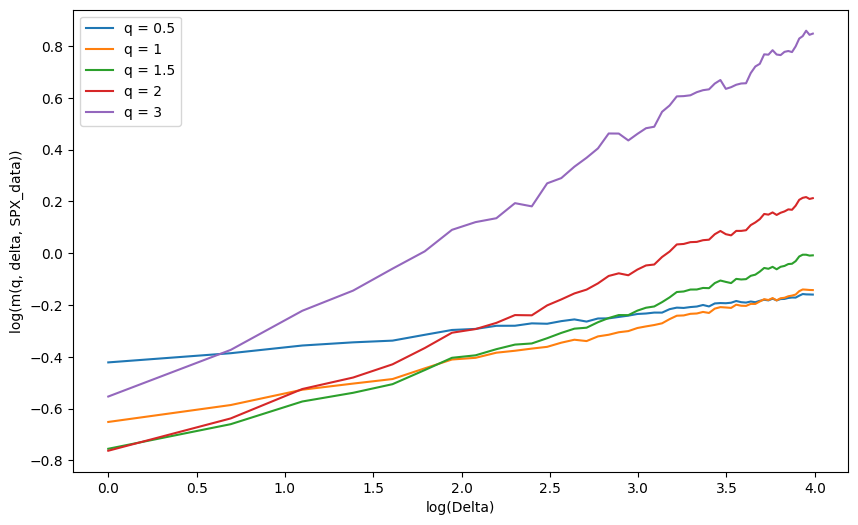

In [25]:
qs = [0.5, 1, 1.5, 2, 3]
deltas = np.arange(1, 55, 1)

SPX_data=datasets['SPX']

plt.figure(figsize=(10, 6))

for q in qs:
    m_values = [np.log(calculate_m(q, delta, SPX_data)) for delta in deltas]
    plt.plot(np.log(deltas), m_values, label=f'q = {q}')

plt.xlabel('log(Delta)')
plt.ylabel('log(m(q, delta, SPX_data))')
plt.legend()
plt.show()


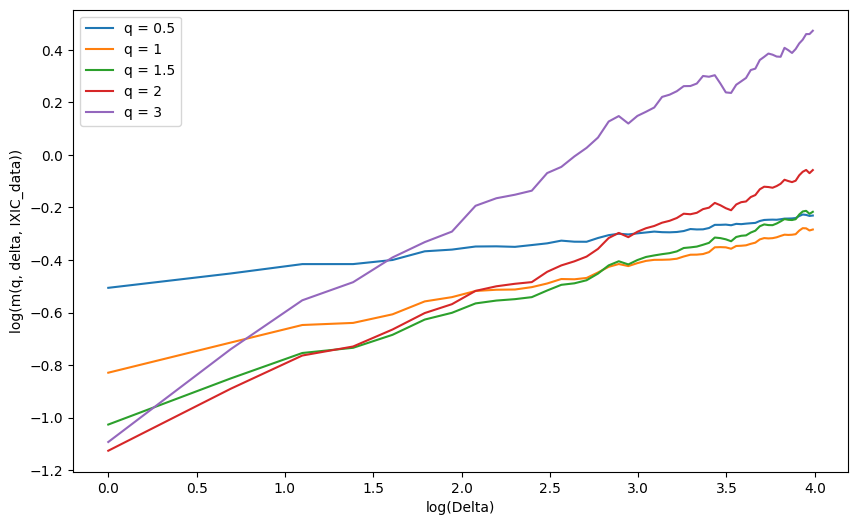

In [26]:
IXIC_data=datasets['IXIC']
plt.figure(figsize=(10, 6))

for q in qs:
    m_values = [np.log(calculate_m(q, delta, IXIC_data)) for delta in deltas]
    plt.plot(np.log(deltas), m_values, label=f'q = {q}')

plt.xlabel('log(Delta)')
plt.ylabel('log(m(q, delta, IXIC_data))')
plt.legend()
plt.show()


In [38]:

import statsmodels.api as sm



results_IXIC_data = {'q': [], 'H_estimate': [], 'p_value': []}

for q in qs:
    m_values = [np.log(calculate_m(q, delta, IXIC_data)) for delta in deltas]

    X = np.log(deltas)
    y = np.array(m_values)
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    H_estimate = results.params[1]
    p_value = results.pvalues[1]

    results_IXIC_data['q'].append(q)
    results_IXIC_data['H_estimate'].append(H_estimate)
    results_IXIC_data['p_value'].append(p_value)

df_results_IXIC_data = pd.DataFrame(results_IXIC_data)

print(df_results_IXIC_data)


     q  H_estimate   p_value
0  0.5    0.081806  0.018653
1  1.0    0.165226  0.000584
2  1.5    0.248412  0.009732
3  2.0    0.330867  0.014266
4  3.0    0.492860  0.017059


In [36]:
results_IXIC_data = {'q': [], 'H_estimate': []}

for q in qs:
    m_values = [np.log(calculate_m(q, delta, IXIC_data)) for delta in deltas]

    X = np.log(deltas).reshape(-1, 1)
    y = np.array(m_values).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)

    H_estimate = reg.coef_[0][0]

    results_IXIC_data['q'].append(q)
    results_IXIC_data['H_estimate'].append(H_estimate)

df_results_IXIC_data = pd.DataFrame(results_IXIC_data)

print(df_results_IXIC_data)

     q  H_estimate
0  0.5    0.081806
1  1.0    0.165226
2  1.5    0.248412
3  2.0    0.330867
4  3.0    0.492860


In [ ]:
results_SPX_data = {'q': [], 'H_estimate': []}
for q in qs:
    m_values = [np.log(calculate_m(q, delta, SPX_data)) for delta in deltas]

    X = np.log(deltas).reshape(-1, 1)
    y = np.array(m_values).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)

    H_estimate = reg.coef_[0][0]

    results_SPX_data['q'].append(q)
    results_SPX_data['H_estimate'].append(H_estimate)

df_results_SPX_data = pd.DataFrame(results_SPX_data)

print(df_results_SPX_data)


     q  H_estimate
0  0.5    0.068447
1  1.0    0.134091
2  1.5    0.196977
3  2.0    0.257140
4  3.0    0.369733


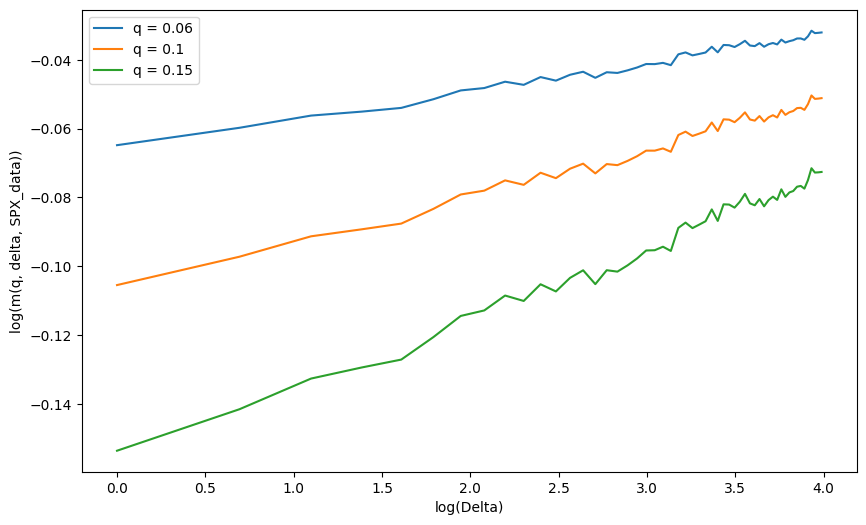

In [39]:
qs = [0.06, 0.1, 0.15]
deltas = np.arange(1, 55, 1)

SPX_data=datasets['SPX']

plt.figure(figsize=(10, 6))

for q in qs:
    m_values = [np.log(calculate_m(q, delta, SPX_data)) for delta in deltas]
    plt.plot(np.log(deltas), m_values, label=f'q = {q}')

plt.xlabel('log(Delta)')
plt.ylabel('log(m(q, delta, SPX_data))')
plt.legend()
plt.show()


In [41]:

results_SPX_data = {'q': [], 'H_estimate': [], 'p_value': []}

for q in qs:
    m_values = [np.log(calculate_m(q, delta, SPX_data)) for delta in deltas]

    X = np.log(deltas)
    y = np.array(m_values)
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    H_estimate = results.params[1]
    p_value = results.pvalues[1]

    results_SPX_data['q'].append(q)
    results_SPX_data['H_estimate'].append(H_estimate)
    results_SPX_data['p_value'].append(p_value)

df_results_SPX_data = pd.DataFrame(results_SPX_data)

print(df_results_SPX_data)


      q  H_estimate       p_value
0  0.06    0.008383  1.019847e-49
1  0.10    0.013940  1.434118e-50
2  0.15    0.020856  1.504066e-51


In [ ]:
q_value = 1

deltas = np.arange(1, 55, 1)

results_all_stocks = {'Symbol': [],  'H_estimate': []}

for symbol, stock_data in datasets.items():
    m_values = [np.log(calculate_m(q_value, delta, stock_data)) for delta in deltas]
    X = np.log(deltas).reshape(-1, 1)
    y = np.array(m_values).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    H_estimate = reg.coef_[0][0]
    results_all_stocks['Symbol'].append(symbol)

    results_all_stocks['H_estimate'].append(H_estimate)

df_results_all_stocks = pd.DataFrame(results_all_stocks)

print(df_results_all_stocks)


    Symbol  H_estimate
0      AEX    0.154745
1     AORD    0.078640
2      BFX    0.143674
3    BSESN    0.127872
4     BVLG    0.114113
5     BVSP    0.129437
6      DJI    0.122616
7     FCHI    0.148520
8    FTMIB    0.120478
9     FTSE    0.124404
10   GDAXI    0.149044
11  GSPTSE    0.079376
12     HSI    0.092494
13    IBEX    0.139108
14    IXIC    0.131452
15    KS11    0.132286
16     KSE    0.123896
17     MXX    0.082581
18    N225    0.129599
19    NSEI    0.114405
20  OMXC20    0.120048
21  OMXHPI    0.124412
22  OMXSPI    0.142130
23   OSEAX    0.111859
24     RUT    0.112805
25    SMSI    0.142871
26     SPX    0.134091
27    SSEC    0.144140


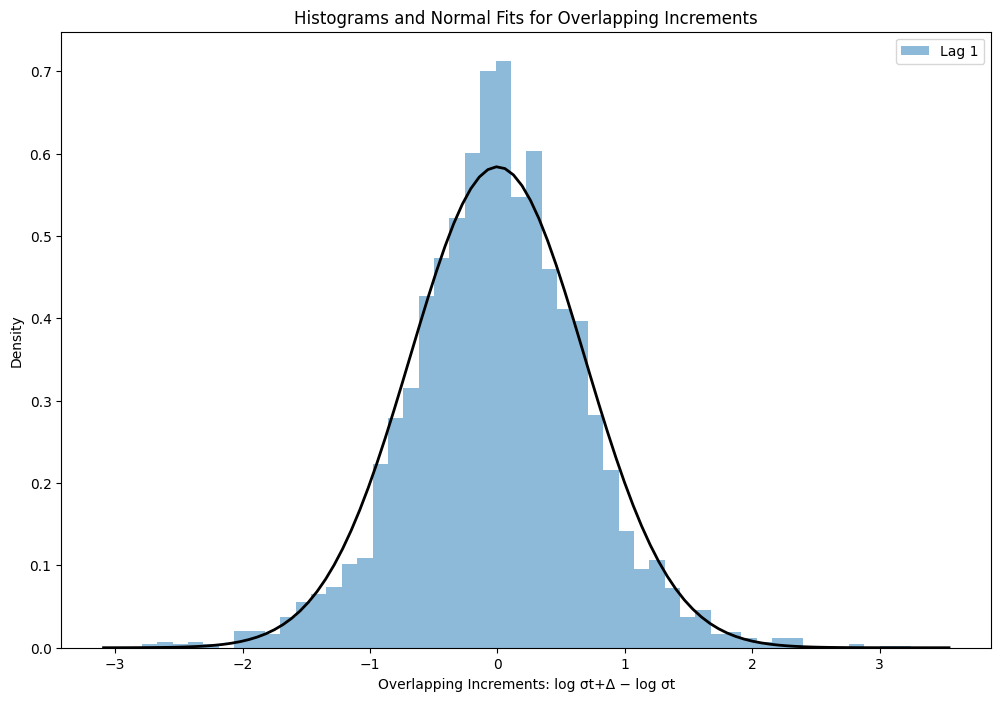

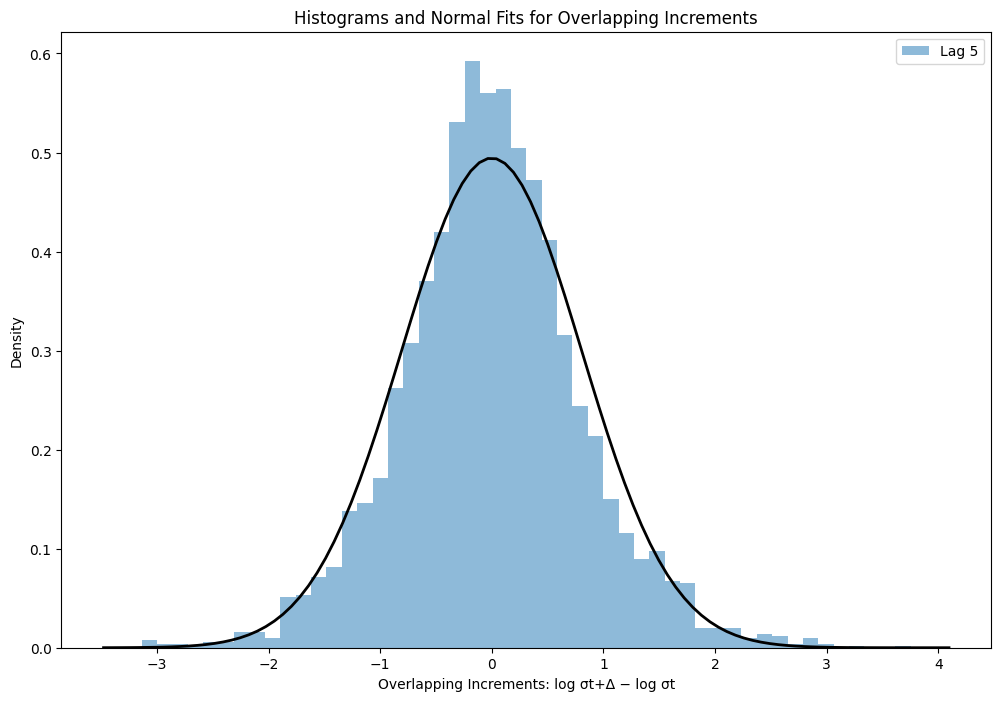

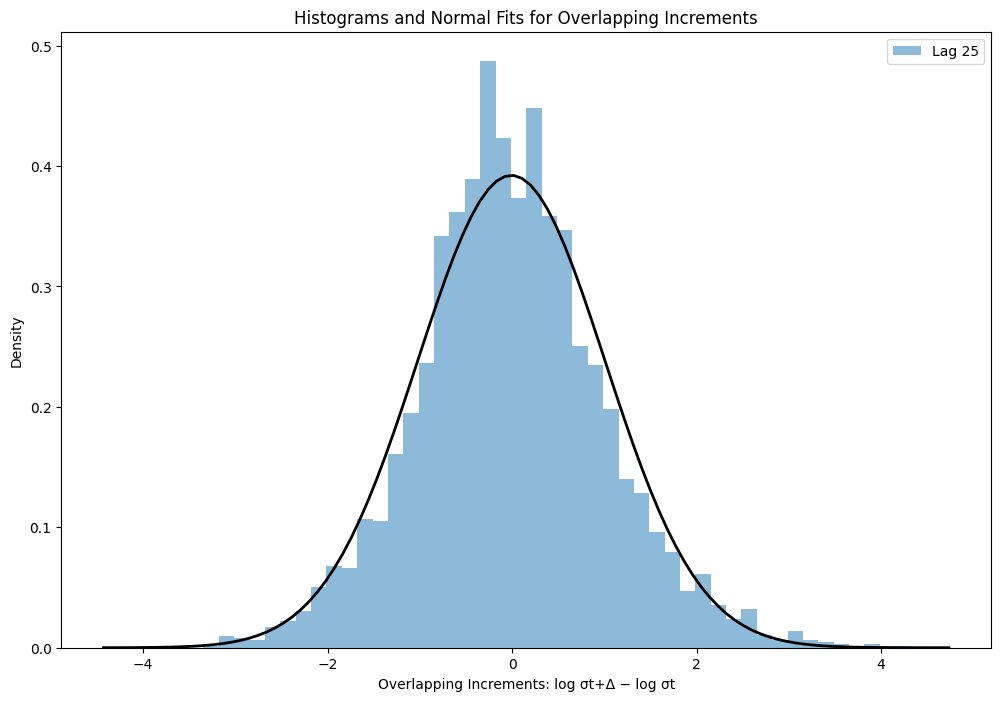

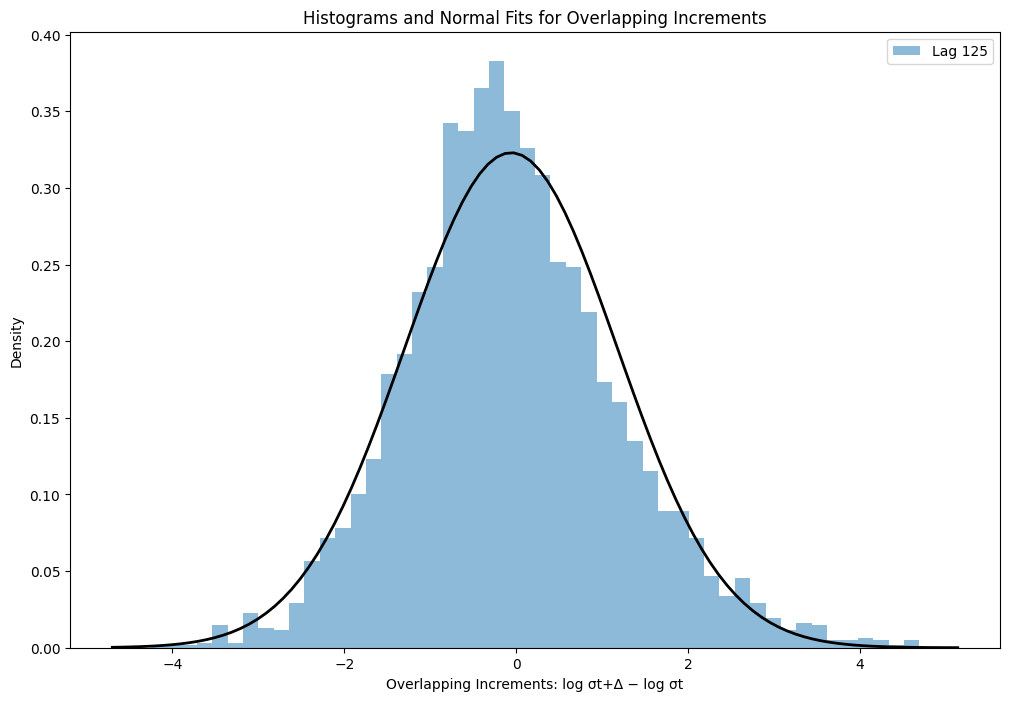

In [ ]:

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler



def calculate_overlapping_increments(data, lag):
    return np.log(data['rv5'].shift(-lag)) - np.log(data['rv5'])



lags = [1, 5, 25, 125]


for lag in lags:
    increments = calculate_overlapping_increments(SPX_data, lag).dropna()
    plt.figure(figsize=(12, 8))

    plt.hist(increments, bins=50, density=True, alpha=0.5, label=f'Lag {lag}')

    mu, std = norm.fit(increments)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)


    plt.title('Histograms and Normal Fits for Overlapping Increments')
    plt.xlabel('Overlapping Increments: log σt+∆ − log σt')
    plt.ylabel('Density')
    plt.legend()
plt.show()


In [ ]:
#to test the hypothesis of stationary increments -> NOT WORKING

midpoint = len(SPX_data['rv5']) // 2
first_half = SPX_data['rv5'].iloc[:midpoint]
second_half = SPX_data['rv5'].iloc[midpoint:]
deltas = np.arange(1, 55, 1)

def estimate_H(data):
    m_values = [np.abs(np.log(data.shift(-delta)) - np.log(data)).dropna().values for delta in deltas]

    min_length = min(len(m) for m in m_values)

    m_values = [m[:min_length] for m in m_values]

    X = np.log(deltas).reshape(-1, 1)
    y = np.vstack(m_values)

    reg = LinearRegression().fit(X, y)
    H_estimate = reg.coef_[0][0]

    return H_estimate

H_estimate_first_half = estimate_H(first_half)
print(f"H estimate for the first half: {H_estimate_first_half}")

H_estimate_second_half = estimate_H(second_half)
print(f"H estimate for the second half: {H_estimate_second_half}")


H estimate for the first half: -0.009344259457876864
H estimate for the second half: 0.56496962965365
